# Exercise 1 - EEG Data Classification with Two Classes

Authors: Quentin Surdez, Aubry Mangold

Here we present the code for the first exercise. We use a basic Multi-Layer
Perceptrons (MLP) to classify between two different states the EEG of a
mouse, awake or asleep. We will choose 25 features and use a 3-fold cross
validaiton to train the model and evaluate it. We use the binary cross
entropy as the loss function and we will use the F1-macro score as the way to
 evaluate. The confusion matrix will also be used

In [3]:
# imports
import numpy as np
import pandas as pd

## Utilities functions

We define the functions that will be used throughout this exercise in the
following cells.

### Data transformation

We define a function to normalize our data. We use a `StandardScaler` and the
 `fit_transform()` function to fit on the same data that we will transform.
This step is crucial in the preprocessing of our data.

In [4]:
from sklearn.preprocessing import StandardScaler

def normalize_data(data_to_fit, data_to_transform):
    scaler = StandardScaler()
    scaler.fit(data_to_fit)
    data = scaler.transform(data_to_transform)
    return data

### Create binary model

Let's define a function to create our binary model. The model will have an
input layer composed of 64 neurons and one hidden layer composed of 32 neurons.
 We
will use the MSE as the loss
function. We use the relu function for the input and the hidden layer and the
 sigmoid for the output neuron. The optimizer chosen is SGD.


In [ ]:
from keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD

# Create binary model
def create_binary_model():
    model = Sequential()
    model.add(Input([25,]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
            # we use stochastic gradient descent
            optimizer=SGD(learning_rate=0.01, momentum=0.9),
            loss="binary_crossentropy",
        )

    return model

mlb = create_binary_model()
mlb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                832       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 865
Trainable params: 865
Non-trainable params: 0
_________________________________________________________________


### Model training

Here is a function to train the model. The function will iterate through the
different folds and train the model on the training data and evaluate it on
the test data. It implements early stopping to reduce overfitting. We 100
epochs for the training and batch size of 32.

In [6]:
from sklearn.model_selection import KFold


def train_model(folds, input_data, output_data, create_model_func):
    history_list = []
    trained_mlb = []
    history = []
    for i, (train_index, test_index) in enumerate(folds):
        print(f"Fold{i+1}/3")

        # We need to create a new model everytime otherwise fit will continue previous training
        mlb = create_model_func()
        # we normalize the data
        scaler = StandardScaler()
        train_input = normalize_data(input_data[train_index],
                                input_data[train_index])
        test_input = normalize_data(input_data[train_index], input_data[test_index])

        # Verify shapes before training
        print(f"Train input shape: {train_input.shape}")
        print(f"Test input shape: {test_input.shape}")

        history = mlb.fit(
            x=train_input, y=output_data[train_index],
            validation_data=(test_input, output_data[test_index]),
            epochs=100,
            verbose=1
        )

        history_list.append(history)
        trained_mlb.append(mlb)
    return history_list, trained_mlb

### Model evaluation

#### Losses

Here is a function to plot the loss graph from the history of the training.

In [ ]:
import matplotlib.pyplot as plt

# here is a function to plot the losses
def plot_losses(history_list):

    # Extract training and validation losses, limiting to min_epochs
    train_losses = np.array([history.history['loss'] for history in history_list])
    val_losses = np.array([history.history['val_loss'] for history in history_list])


    # Calculate mean and standard deviation for training and validation losses
    mean_train_loss = np.mean(train_losses, axis=0)
    std_train_loss = np.std(train_losses, axis=0)
    mean_val_loss = np.mean(val_losses, axis=0)
    std_val_loss = np.std(val_losses, axis=0)

    # Plot mean and standard deviation for training loss
    plt.plot(mean_train_loss, label='Training Loss (Mean)')
    plt.fill_between(range(len(mean_train_loss)), mean_train_loss -
                     std_train_loss, mean_train_loss + std_train_loss,
                     alpha=0.3, label='Training Loss (Std)')

    # Plot mean and standard deviation for validation loss
    plt.plot(mean_val_loss, label='Validation Loss (Mean)')
    plt.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss,
                     mean_val_loss + std_val_loss, alpha=0.3,
                     label='Validation Loss (Std)')

    # Add labels and legend
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()

#### Confusion Matrix and F1 scores

Here is a function to plot the confusion matrix and retrieve the F1 scores.
We use the F1 macro score to plot the confusion matrix.

In [8]:
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as pl
import seaborn as sns

# Plot confusion matrix
def plot_confusion_matrix(confusion_matrix, title):
    pl.figure(figsize=(10, 8))
    ax = sns.heatmap(confusion_matrix.astype(int), annot=False, fmt="d", cmap="Blues", cbar=False,
                     xticklabels=["asleep", "awake"], yticklabels=["asleep", "awake"],
                     annot_kws={"size": 10})
    pl.title(title)

    pl.xlabel('Predicted')
    pl.ylabel('True')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            x = j + 0.5  # Shift x-coordinate to center the text
            y = i + 0.5  # Shift y-coordinate to center the text
            ax.text(x, y, str(confusion_matrix[i, j]), ha="center", va="center", color="black")

    pl.show()

# Evaluate the trained model on the test fold
def test_model(model, test_input, test_output):
    predictions = model.predict(test_input)
    true_labels = (test_output > 0.5).astype(int)
    predicted_labels = (predictions > 0.5).astype(int)  # Get the index of the
    # maximum value as the predicted labels
    cm = confusion_matrix(true_labels, predicted_labels)
    # Compute confusion matrix
    f1 = f1_score(true_labels, predicted_labels, average='macro')  # Use macro averaging for multi-class classification
    return cm, f1


## Let's train our Model !

Now that we have defined our function, we can preprocess the data and train
our model on it.

### Preprocess

We first need to load and preprocess the data given.

In [9]:
# Load the data
mouse1 = pd.read_csv('pw3_data/EEG_mouse_data_1.csv')
mouse2 = pd.read_csv('pw3_data/EEG_mouse_data_2.csv')

# Combine training data
train_data = pd.concat([mouse1, mouse2], ignore_index=True)


We then extract the features that are relevant for our training.

In [10]:
features = train_data.drop(['state'], axis=1)
labels = train_data['state']

selected_features = [
    'amplitude_around_1_Hertz', 'amplitude_around_2_Hertz',
    'amplitude_around_3_Hertz', 'amplitude_around_4_Hertz',

    'amplitude_around_5_Hertz', 'amplitude_around_6_Hertz',
    'amplitude_around_7_Hertz', 'amplitude_around_8_Hertz',

    'amplitude_around_9_Hertz', 'amplitude_around_10_Hertz',
    'amplitude_around_11_Hertz', 'amplitude_around_12_Hertz',
    'amplitude_around_13_Hertz',

    'amplitude_around_14_Hertz', 'amplitude_around_15_Hertz',
    'amplitude_around_16_Hertz', 'amplitude_around_17_Hertz',
    'amplitude_around_18_Hertz', 'amplitude_around_19_Hertz',

    'amplitude_around_20_Hertz', 'amplitude_around_21_Hertz',
    'amplitude_around_22_Hertz', 'amplitude_around_23_Hertz',
    'amplitude_around_24_Hertz', 'amplitude_around_25_Hertz',

]

# Choose only selected features among all the features
input_data = np.array(features[selected_features])
input_data = input_data.astype('float32')

# We transform the labels to a binary value 1 for awake and 0 for asleep
output_data = np.where(labels == 'w', 1.0, 0.0)
output_data = output_data.astype('float32')


# Print shapes for verification
print(f"Full input data shape: {input_data.shape}")
print(f"Full output data shape: {output_data.shape}")


Full input data shape: (40863, 25)
Full output data shape: (40863,)


### Train the Model

We now train the model with the function we made previously

In [11]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)

history_list, trained_mlb = train_model(kf.split(input_data), input_data,
                                        output_data, create_binary_model )


Fold1/3
Train input shape: (27242, 25)
Test input shape: (13621, 25)
Epoch 1/100


2025-04-08 18:07:17.375406: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


852/852 [==============================] - 2s 1ms/step - loss: 0.2994 - val_loss: 0.2882
Epoch 2/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2803 - val_loss: 0.2828
Epoch 3/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2755 - val_loss: 0.2818
Epoch 4/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2725 - val_loss: 0.2806
Epoch 5/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2708 - val_loss: 0.2782
Epoch 6/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2700 - val_loss: 0.2770
Epoch 7/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2689 - val_loss: 0.2765
Epoch 8/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2671 - val_loss: 0.2759
Epoch 9/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2661 - val_loss: 0.2812
Epoch 10/100
852/852 [==============================] - 1s 1ms/step - loss: 0.2664 - val_loss: 0.2779
E

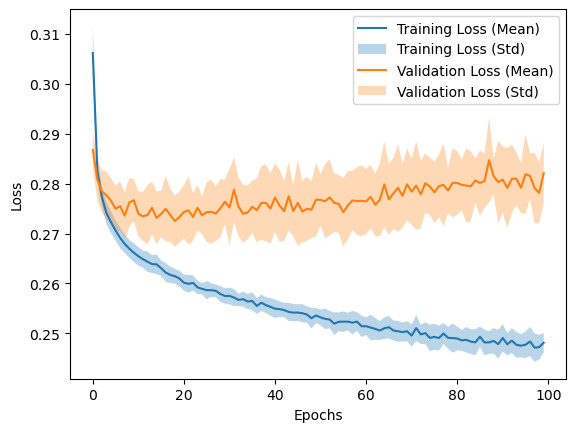

In [12]:
plot_losses(history_list)

### Confusion Matrix and F1 Scores

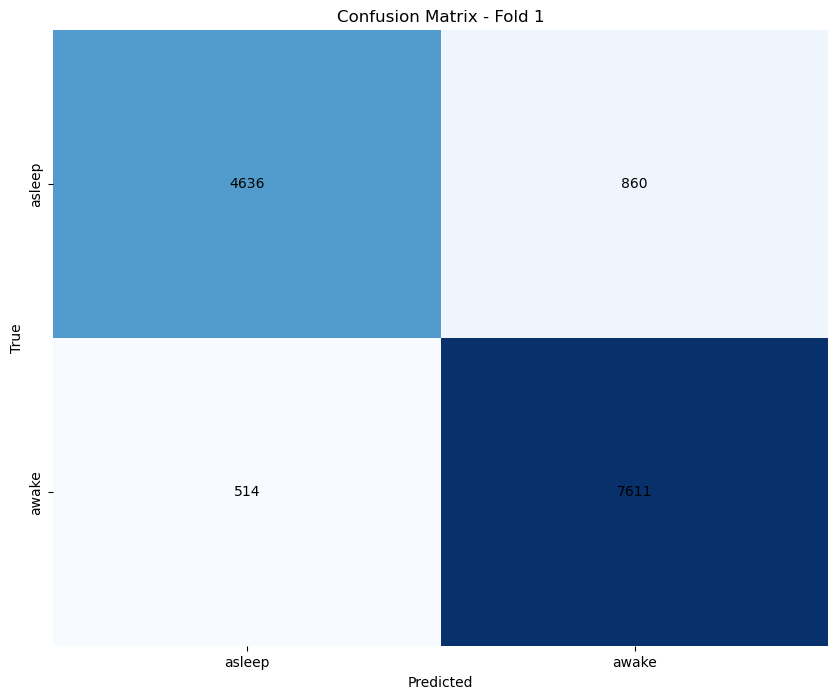

F1 Score - Fold 1: 0.8940732036542058


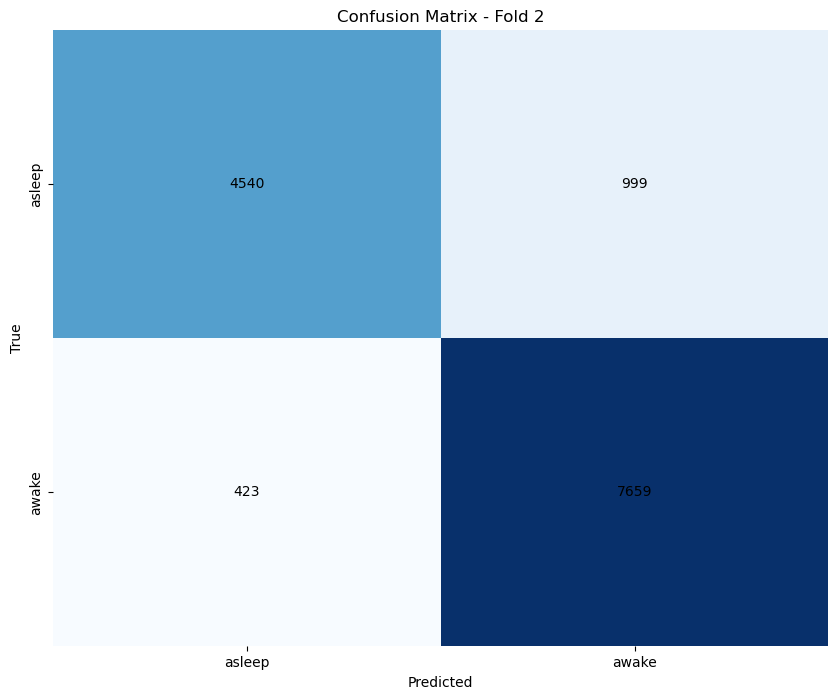

F1 Score - Fold 2: 0.8898254915090418


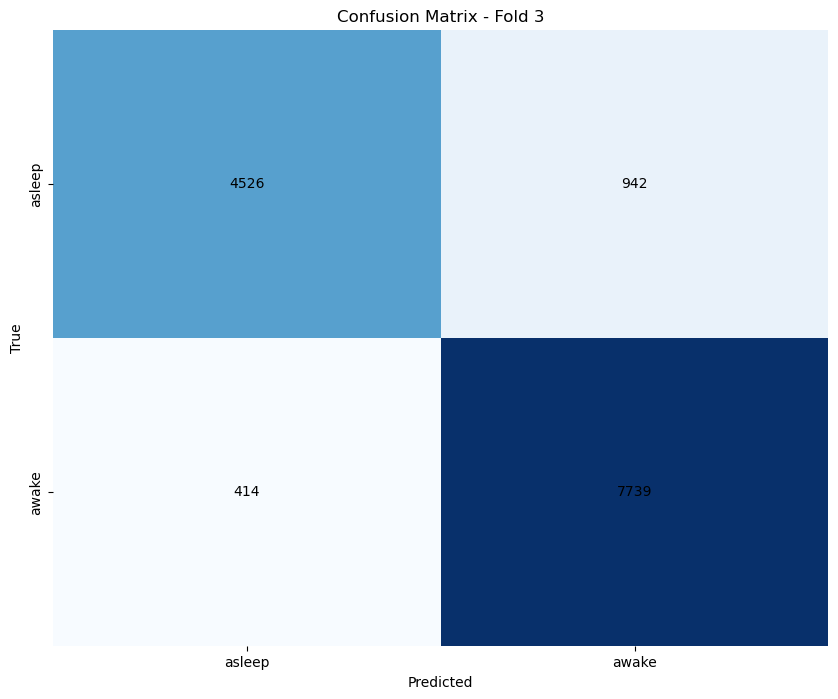

F1 Score - Fold 3: 0.894582169042795


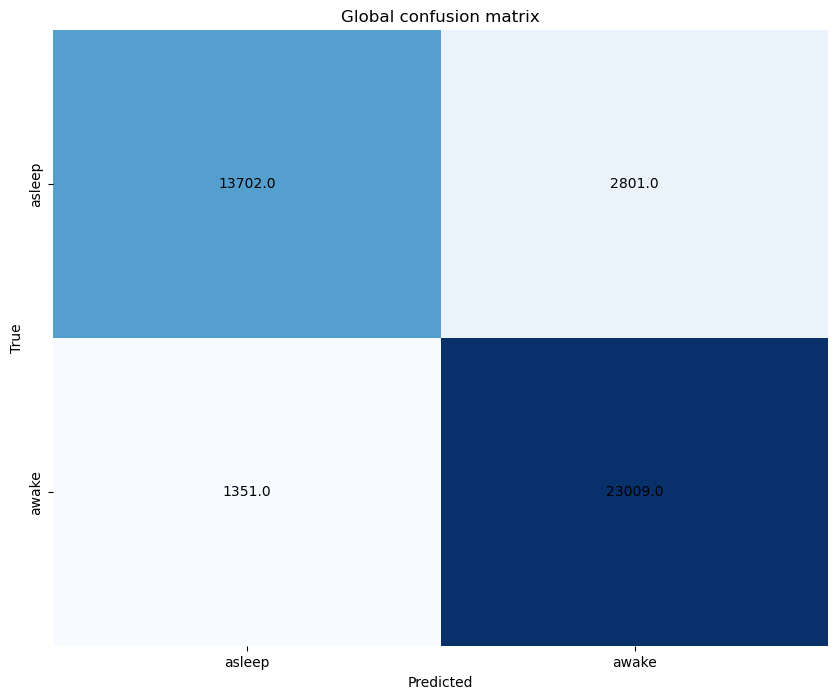

Mean F1 Score across all folds: 0.8928269547353476


In [13]:
from sklearn.preprocessing import StandardScaler
kf = KFold(n_splits=3, shuffle=True, random_state=123)
f1_scores = []
mean_confusion_matrix = np.zeros((2, 2))


for i, (train_index, test_index) in enumerate(kf.split(input_data)):

    test_data = normalize_data(input_data[train_index], input_data[test_index])

    cm, f1 = test_model(trained_mlb[i], test_data, output_data[test_index])

    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')
    mean_confusion_matrix += cm

    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")


# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")